In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import date, datetime 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# load data and some quick EDA

In [3]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Load"

In [4]:
NYC = []
for y in range(2017,2023):
# for y in [2022]:
  df = pd.read_csv(f"{DATA_DIR}/Load_{y}.csv", index_col = 'Time Stamp', usecols = ['N.Y.C.', 'Time Stamp'])
  NYC.append(df)
NYC = pd.concat(NYC)
NYC = NYC['N.Y.C.']
NYC.index = pd.to_datetime(NYC.index)
NYC = NYC.asfreq('5T')
n = len(NYC.index)
t = int(250*24*(60/5))

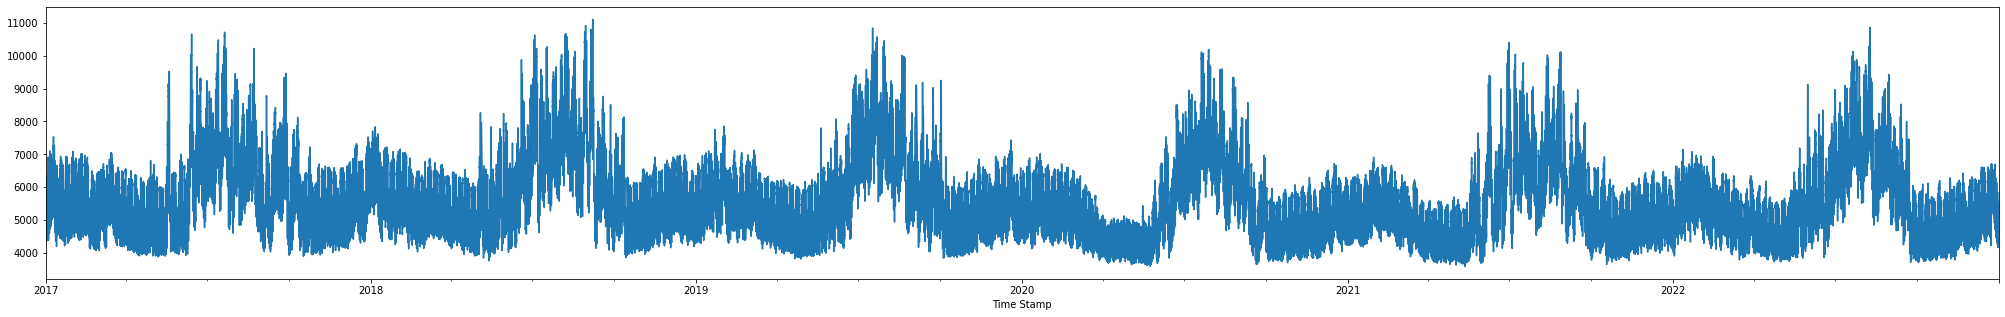

In [5]:
NYC.plot(figsize = (35,5))
# data looks relatively stationay, but there is a clear seasonality that summer month comsumes more enerrgy 
# however, 2017-04-01 - 2017-04-24 and 2021-04-01 - 2021-04-07 are missing

In [35]:
# split the train an validate data set 
# use data after 2014.4.25 to avoid large gap in data, and use 2022 for validation

train,validate = NYC[(NYC.index<datetime(2022,1,1))], NYC[NYC.index>=datetime(2022,1,1)]

In [7]:
mean1, mean2 = train.mean(), validate.mean()
var1, var2 = train.var(), validate.var()
print('mean train=%f, mean validate=%f' % (mean1, mean2))
print('variance train=%f, variance validate=%f' % (var1, var2))

# variance significantly larger than mean , implying seasonality exists. 
# summer month are more demanding than winter times 

mean train=5833.801459, mean validate=5687.832418
variance train=1582737.697866, variance validate=1404557.119282


In [13]:
# running an Augmented Dickey-Fuller test to see if the data set is stationary
# https://machinelearningmastery.com/time-series-data-stationary-python/
# not enough RAM on colab to run the test on entire dataset so trying 2 year
result = adfuller(train[(train.index.year==2018) | (train.index.year==2019) ].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# This suggests that we can reject the null hypothesis with a significance level of less than 1% 
# Rejecting the null hypothesis, time series is stationary 
# Given stationary, can use d=0

ADF Statistic: -20.237001
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


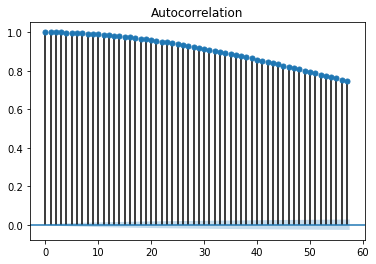

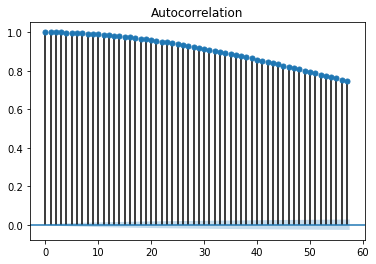

In [12]:
plot_acf(train.values)
# but autocorrelation shows to much correalation 

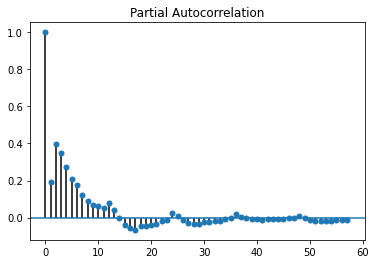

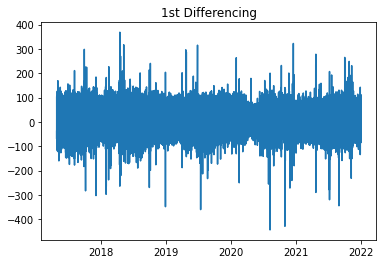

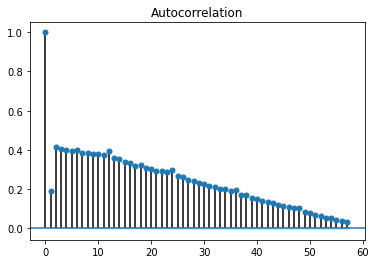

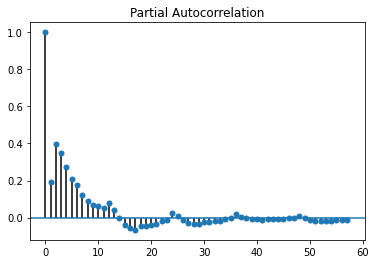

In [33]:
# 1st Differencing
plt.plot(train.diff())
plt.title('1st Differencing')
plot_acf(train.diff().dropna())
plot_pacf(train.diff().dropna())

# 1st order differencing shows better stantionary, so will take 1st differece, with AR, MA order of 1

In [7]:

model = ARIMA(NYC, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                 N.Y.C.   No. Observations:               632273
Model:                 ARIMA(1, 1, 1)   Log Likelihood            -2890994.670
Date:                Sun, 05 Feb 2023   AIC                        5781995.340
Time:                        16:00:58   BIC                        5782029.412
Sample:                             0   HQIC                       5782004.893
                             - 632273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9888      0.000   4438.844      0.000       0.988       0.989
ma.L1         -0.8893      0.001  -1460.308      0.000      -0.890      -0.888
sigma2       548.3558      0.552    992.984      0.0

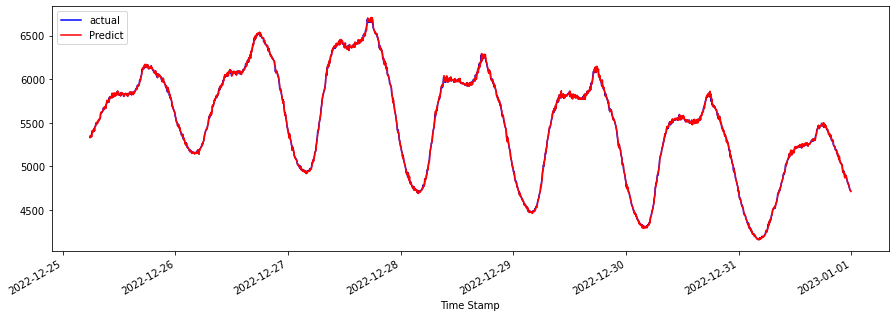

In [51]:
plt.figure(figsize=(15,5))

ax1 = NYC[-7*24*12:].plot(color='blue',  label='Actual')
ax2 = pred[-7*24*12:].plot(color='red',  label='Predict')

h1, l1 = ax1.get_legend_handles_labels()
plt.legend(h1, l1, loc=2)
plt.show()

In [67]:
# Setup forecasts
nforecasts = 18
forecasts_dict = {}

# Get the number of initial training observations
nobs = len(NYC)
n_init_training = len(train)

# Create model for initial training sample, fit parameters
mod = SARIMAX(train, order=(1, 1, 1))
res = mod.fit()

# Save initial forecast
forecasts_dict[train.index[-1]] = res.forecast(steps=nforecasts).values

# Step through the rest of the sample
for t in range(n_init_training+1, nobs):
# for t in range(n_init_training, nobs):
    # Update the results by appending the next observation
    updated_endog = NYC.iloc[t:t+1]
    res = res.extend(updated_endog.values)

    # Save the new set of forecasts
    forecasts_dict[updated_endog.index[0]] = res.forecast(steps=nforecasts).values

# Combine all forecasts into a dataframe
forecasts = pd.DataFrame.from_dict(forecasts_dict, orient='index')

forecasts

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
2021-12-31 23:55:00,4663.195745,4649.567662,4636.092516,4622.768592,4609.594191,4596.567636,4583.687267,4570.951445,4558.358547,4545.906968,4533.595124,4521.421446,4509.384383,4497.482403,4485.713989,4474.077643,4462.571882,4451.195241
2022-01-01 00:05:00,4606.260519,4588.811081,4571.557464,4554.497471,4537.628929,4520.949689,4504.457627,4488.150642,4472.026657,4456.083619,4440.319497,4424.732283,4409.319992,4394.080661,4379.012349,4364.113136,4349.381126,4334.814441
2022-01-01 00:10:00,4628.660659,4615.064035,4601.619994,4588.326825,4575.182835,4562.186349,4549.335713,4536.629289,4524.065458,4511.642622,4499.359198,4487.213620,4475.204343,4463.329836,4451.588587,4439.979101,4428.499900,4417.149519
2022-01-01 00:15:00,4590.350694,4574.638713,4559.103055,4543.741740,4528.552814,4513.534341,4498.684408,4484.001125,4469.482620,4455.127044,4440.932570,4426.897389,4413.019714,4399.297777,4385.729830,4372.314146,4359.049014,4345.932747
2022-01-01 00:20:00,4573.243530,4557.579835,4542.091922,4526.777818,4511.635571,4496.663254,4481.858959,4467.220801,4452.746916,4438.435459,4424.284608,4410.292561,4396.457536,4382.777770,4369.251521,4355.877067,4342.652703,4329.576746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:35:00,4736.826514,4724.110350,4711.536890,4699.104532,4686.811692,4674.656805,4662.638323,4650.754714,4639.004466,4627.386082,4615.898081,4604.539001,4593.307395,4582.201832,4571.220898,4560.363195,4549.627338,4539.011962
2022-12-31 23:40:00,4725.775369,4713.354708,4701.073434,4688.929982,4676.922807,4665.050379,4653.311186,4641.703733,4630.226540,4618.878147,4607.657108,4596.561994,4585.591391,4574.743903,4564.018147,4553.412758,4542.926385,4532.557692
2022-12-31 23:45:00,4719.408830,4707.683142,4696.089042,4684.625054,4673.289716,4662.081586,4650.999236,4640.041255,4629.206246,4618.492829,4607.899641,4597.425332,4587.068568,4576.828029,4566.702412,4556.690426,4546.790797,4537.002264
2022-12-31 23:50:00,4709.940853,4698.553943,4687.294820,4676.162048,4665.154210,4654.269905,4643.507746,4632.866362,4622.344397,4611.940512,4601.653382,4591.481696,4581.424159,4571.479489,4561.646420,4551.923701,4542.310091,4532.804367


In [68]:
forecasts.to_csv('/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/ARIMA_forecast.csv')

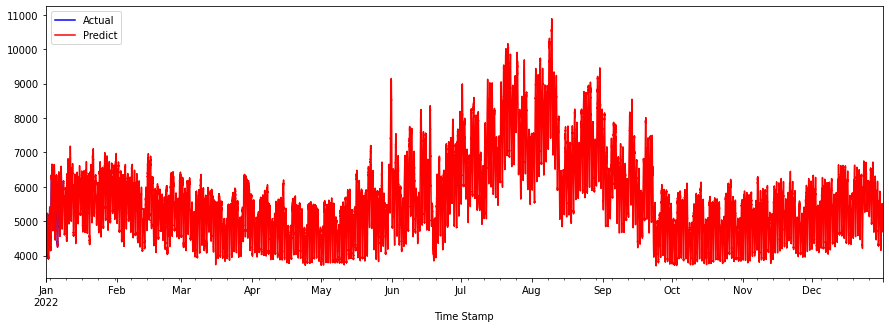

In [69]:
plt.figure(figsize=(15,5))

ax1 =validate[:7*24*12].plot(color='blue',  label='Actual')
ax2 = forecasts[1].plot(color='red',  label='Predict')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()